# Tutorial 6: Two-Step Refinement Process

Often times,we will want to use `Chromo` to evaluate full-chromosome simulations. This can be computationally expensive and prone to frustration. To mitigate this, we can use a two-step refinement process. In the first step, we can use a coarse-grained model to evaluate the full-chromosome simulation and get an approximate location of large chromatin segments. We then refine the resolution of the coarse-grained model and re-equilibrate the system. This tutorial will demonstrate how to use a two-step refinement process to evaluate full-chromosome simulations.

|

#### Import Modules

The coarse-graining and refining processes are handled by the `chromo.util.rediscretize` module.

In [1]:
# Built-in modules
import os
import sys
from inspect import getmembers, isfunction

# Third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from chromo.binders import get_by_name, make_binder_collection
from chromo.polymers import Chromatin
from chromo.fields import UniformDensityField
import chromo.mc as mc
import chromo.mc.mc_controller as ctrl
from chromo.util.reproducibility import get_unique_subfolder_name
import chromo.util.mu_schedules as ms
import chromo.util.rediscretize as rd    # Handles the coarse-graining and refining processes

|

#### Specify Binders

For this demonstration, we will include two epigenetic marks (H3K9me3 and H3K27me3) and their binders (HP1 and PRC1).

In [2]:
# Instantiate HP1 and PRC1 reader proteins
hp1 = get_by_name('HP1')
prc1 = get_by_name('PRC1')

In [3]:
# Set the HP1-PRC1 cross interaction to 1.0 kT
hp1.cross_talk_interaction_energy["PRC1"] = 1.0

# Set the HP1 and PRC1 chemical potentials to -1.2 kT
hp1.chemical_potential = -1.2
prc1.chemical_potential = -1.2

In [4]:
# Create a binder collection with the HP1 and PRC1 reader proteins
binder_collection = make_binder_collection([hp1, prc1])

|

#### Specify the Confinement

In [5]:
confine_type = "Spherical"
confine_radius = 200.0

|

#### Instantiate Epigenetic Mark Pattern

When we define the epigenetic mark pattern, we do so at the **full resolution** that we want to obtain following refinement. The epigenetic mark pattern will be rediscretized to generate the coarse-grained mark pattern. 

In [6]:
num_beads = 1000
mark_pattern = np.zeros((num_beads, 2), dtype=int)
mark_names = np.array(["H3K9me3", "H3K27me3"])
mark_pattern[:500, 0] = 2
mark_pattern[500:, 1] = 2
print("Shape of mark pattern:", mark_pattern.shape)

Shape of mark pattern: (1000, 2)


|

#### Specify Initial Reader Protein Binding States

Again, we specify the initial reader protein binding states at the **full resolution** that we want to obtain following refinement. The reader protein binding states will be rediscretized to generate the coarse-grained binding states.

In [7]:
binder_names = np.array([hp1.name, prc1.name])
states = np.zeros((num_beads, 2), dtype=int)

|

#### Instantiate the Polymer

We will instantiate the polymer as a `Chromatin` object at full resolution.

In [8]:
# Specify the name, number of beads, and bead spacing of the chromatin fiber
name = "Chr"
bead_spacing = np.ones(num_beads - 1) * 16.5

# Instantiate the chromatin fiber
poly = Chromatin.confined_gaussian_walk(
    name,
    num_beads,
    bead_spacing,
    confine_type=confine_type,
    confine_length=confine_radius,
    states=states,
    binder_names=binder_names,
    chemical_mods=mark_pattern,
    chemical_mod_names=mark_names,
    max_binders=2
)

|

#### Specify the Uniform Density Field

The uniform density field is originally specified based on the **full resolution** chromatin fiber.

In [9]:
 # Specify the dimensions of the field
n_accessible = int(np.round((63 * confine_radius) / 900))
n_buffer = 2
n_bins_x = n_accessible + n_buffer
x_width = 2 * confine_radius * (1 + n_buffer/n_accessible)
n_bins_y = n_bins_x
y_width = x_width
n_bins_z = n_bins_x
z_width = x_width

# Initialize the uniform density field
udf = UniformDensityField(
    [poly],
    binder_collection,
    x_width,
    n_bins_x,
    y_width,
    n_bins_y,
    z_width,
    n_bins_z,
    confine_type=confine_type,
    confine_length=confine_radius,
    chi=1,
    assume_fully_accessible=1,
    fast_field=0
)

|

#### Specify the Coarse-Grained Model

We then coarse-grain the polymer and the field by reducing the number of beads by a fixed factor. In this demonstration, we will reduce the number of beads by a factor of 10.

In [10]:
# Specify the factor by which to coarse-grain the polymer and field
cg_factor = 10

There are two ways to generate the epigenetic mark pattern in the coarse-grained chromatin fiber:

**(1)** One method involves selecting random epigenetic mark states from fixed-length, non-overlapping segments along the chromatin fiber; stated differently, for each coarse-grained bead, we specify the bead's mark identity by randomly selecting an epigenetic state from the full-resolution beads represented by it. To initialize epigenetic mark patterns in this way, specify `random_states=True` when coarse-graining the chromatin fiber.

**(2)** The other way involves selecting the most common epigenetic mark state from fixed-length, non-overlapping segments along the chromatin fiber; stated differently, for each coarse-grained bead, we specify the bead's mark identity by selecting the most common epigenetic state from the full-resolution beads represented by it. To initialize epigenetic mark patterns in this way, specify `random_states=False` when coarse-graining the chromatin fiber, or do not specify `random_states` at all. 

When evaluated chromatin structure using an ensemble of coarse-grained representations, the first method does a better job capturing the average behavior of each chromatin segment represented by the coarse-grained beads. To avoid running replicate simulations, we will proceed with the second method.

In [11]:
poly_cg = rd.get_cg_chromatin(
    polymer=poly,
    cg_factor=cg_factor,
    name_cg="Chr_CG"
)
udf_cg = rd.get_cg_udf(
    udf_refined_dict=udf.dict_,
    binders_refined=binder_collection,
    cg_factor=cg_factor,
    polymers_cg=[poly_cg]
)
binders_cg = rd.get_cg_binders(
    binders_refined=binder_collection,
    cg_factor=cg_factor
)

|

#### Specify the Simulation Parameters

For the purposes of this demonstration, I will significantly reduce the number of mc steps per snapshot. This will allow us to run the simulation faster. **The simulations will not be equilibrated!** For more rigorous simulations, increase the number of mc steps per snapshot to ensure that the system reaches equilibrium.

We specify the simulation parameters based on the **coarse-grained** chromatin fiber at this step.

In [12]:
amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds(
    polymers = [poly_cg]
)

In [13]:
# Specify the number of snapshots and the number of MC steps to attempt per snapshot
num_snapshots = 200
mc_steps_per_snapshot = 10  # Reduce the number of MC steps per snapshot to speed up the simulation
# TODO: If you want to run a more rigorous simulation, increase the number of MC steps per snapshot

In [14]:
# Create a list of simulated annealing schedules, which are defined in another file
schedules = [func[0] for func in getmembers(ms, isfunction)]

# Select a schedule for slowly adding HP1 into the system
select_schedule = "linear_step_for_negative_cp"
mu_schedules = [
    ms.Schedule(getattr(ms, func_name)) for func_name in schedules
]
mu_schedules = [sch for sch in mu_schedules if sch.name == select_schedule]

|

#### Run the Coarse-Grained Simulation

The output of the simulation will be a coarse-grained representation of the chromatin fiber.

In [ ]:
# Specify the output directory
out_dir = "output_demo"

# Run the simulation
polymers = mc.polymer_in_field(
    [poly_cg],
    binders_cg,
    udf_cg,
    mc_steps_per_snapshot,
    num_snapshots,
    amp_bead_bounds,
    amp_move_bounds,
    output_dir=out_dir,
    mu_schedule=mu_schedules[0],
)

|

#### Plot the Coarse-Grained Chromatin Fiber

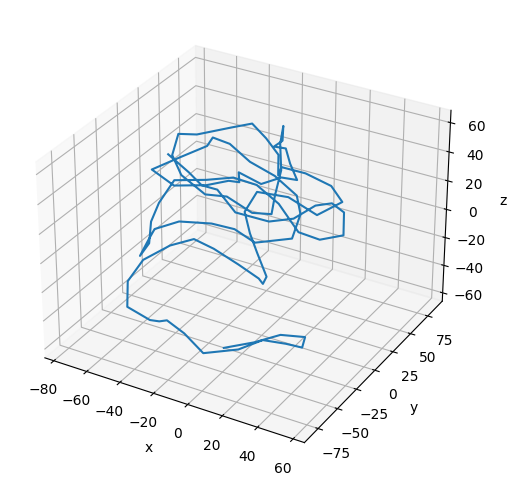

In [16]:
# Plot the final configuration of the polymer
x = polymers[0].r[:, 0]
y = polymers[0].r[:, 1]
z = polymers[0].r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(np.asarray(x), np.asarray(y), np.asarray(z))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [17]:
print(f"Number of Beads in the Coarse-Grained Chromatin Fiber: {polymers[0].num_beads}")

Number of Beads in the Coarse-Grained Chromatin Fiber: 100


|

#### Refine the Coarse-Grained Model

With the coarse-grained simulation equilibrated, we have an approximation of where genomic segments lie in space, relative to one-another. We can now insert beads back into the model and re-equilibrate the configuration to get a higher-resolution representation of the chromatin fiber. While we know the epigenetic mark pattern for the refined model (since it was specified prior to coarse-graining), we do not know the reader protein binding states. We allow a certain number of MC steps to equilibrate the binding states prior to proposing geometric moves to the refined chromatin fiber.

|

#### Important Consideration

As of July 3, 2024, only uniform linker lengths are supported by the refinement step. This can be modified during future development.

In [18]:
# Specify how many binding moves to attempt prior to proposing geometric moves
# This should be increased (e.g., to 1000000) for a more rigorous simulation
n_bind_eq = 100

# Specify the spacing between beads in the refined chromatin fiber
bead_spacing = 16.5  # Currently, only uniform linker lengths are supported

# Refine the coarse-grained model
poly_refine, udf_refine = rd.refine_chromatin(
    polymer_cg=polymers[0],    # This comes from the output of the coarse-grained model
    num_beads_refined=num_beads,
    bead_spacing=bead_spacing,
    chemical_mods=mark_pattern,
    udf_cg=udf_cg,
    binding_equilibration=n_bind_eq,
    name_refine="Chr_refine",
    output_dir=out_dir
)

|

#### Specify the Simulation Parameters

Now, re-specify simulation parameters based on the refined polymer. Notice, you do not want to apply simulated annealing to reader protein chemical potentials. If the approximate configuration generated by the coarse step is lost due to a large change in chemical potential, then the two-step refinement process is not useful.

In [20]:
# Specify move and bead amplitudes
amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds([poly_refine])

In [21]:
# Specify the number of snapshots and the number of MC steps to attempt per snapshot
num_snapshots = 200
mc_steps_per_snapshot = 10  # Reduce the number of MC steps per snapshot to speed up the simulation
# TODO: If you want to run a more rigorous simulation, increase the number of MC steps per snapshot

|

#### Run the Refined Simulation

The output of the simulation will be a refined representation of the chromatin fiber.

In [ ]:
# Run the refined simulation
polymers_refined = mc.polymer_in_field(
    [poly_refine],
    binder_collection,    # This was specified prior to coarse-graining
    udf_refine,
    mc_steps_per_snapshot,
    num_snapshots,
    amp_bead_bounds,
    amp_move_bounds,
    output_dir=out_dir,
)

|

#### Plot the Refined Chromatin Fiber

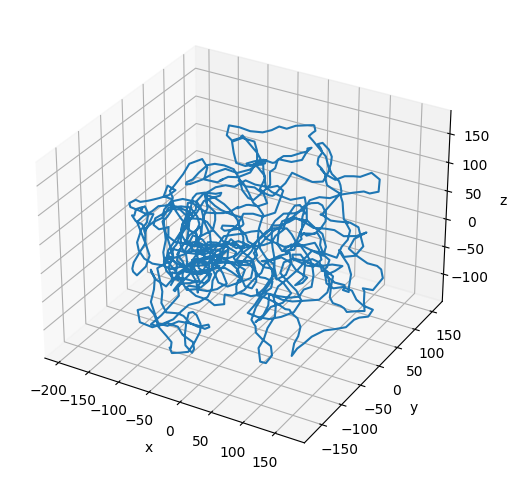

In [23]:
# Plot the final configuration of the polymer
x = polymers_refined[0].r[:, 0]
y = polymers_refined[0].r[:, 1]
z = polymers_refined[0].r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(np.asarray(x), np.asarray(y), np.asarray(z))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [24]:
print(f"Number of Beads in the Refined Chromatin Fiber: {polymers_refined[0].num_beads}")

Number of Beads in the Refined Chromatin Fiber: 1000
